In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

In [2]:
df = pd.read_csv("/Users/olivia/Desktop/Compulational Statistics/HW/HW6/Survey Results_v1.1.csv", header=1)
rating = df.iloc[15:34,].reset_index(drop=True)
rating.index = rating['Name']
rating.drop(['Unnamed: 1','Name'], axis=1, inplace=True)

rating_t = rating.transpose(copy=True) 
rating_t.head() # 46 users * 20 movies 

Name,The Shawkshank Redemption,The Godfather,The Dark Knight,The Godfather Part II,The Lord of the Rings III,Pulp Fiction,Schindler's List,"The Good, the Bad and the Ugly",12 Angry Men,Inception,Fight Club,The Lord of the Rings I,Forrest Group,Star Wars V the Empire Strikes Back,The Lord of the Rings II,The Matrix,Goodfellas,One Flew over the Cuckoo's Nest,Seven Samural
A McCandlish,3,2,3,2,2,1,2,1,4,4,4,2,4,2,2,5,2,1,0
Y Zhao,4,4,5,4,4,4,5,3,4,4,4,4,5,3,3,5,4,4,4
Patrick,0,0,0,0,0,0,0,4,0,0,0,1,2,0,0,2,3,0,0
Y Li,5,4,3,2,3,4,3,3,0,0,0,3,3,2,0,3,0,4,2
N Ghebre,0,3,5,0,5,0,0,4,0,0,0,0,5,4,5,3,0,0,0


In [3]:
rating_stack = rating_t.stack().reset_index()
rating_stack.columns = ['user_name','item_name','rating']
rating_stack

,user_name,item_name,rating
0,A McCandlish,The Shawkshank Redemption,3
1,A McCandlish,The Godfather,2
2,A McCandlish,The Dark Knight,3
3,A McCandlish,The Godfather Part II,2
4,A McCandlish,The Lord of the Rings III,2
...,...,...,...
869,M Zhang,The Lord of the Rings II,0
870,M Zhang,The Matrix,4
871,M Zhang,Goodfellas,0
872,M Zhang,One Flew over the Cuckoo's Nest,0


In [4]:
rating_stack2 = rating_stack.drop(rating_stack[rating_stack['rating']=='0'].index, axis=0) 
rating_stack2

,user_name,item_name,rating
0,A McCandlish,The Shawkshank Redemption,3
1,A McCandlish,The Godfather,2
2,A McCandlish,The Dark Knight,3
3,A McCandlish,The Godfather Part II,2
4,A McCandlish,The Lord of the Rings III,2
...,...,...,...
861,M Zhang,Schindler's List,5
865,M Zhang,Fight Club,5
866,M Zhang,The Lord of the Rings I,5
868,M Zhang,Star Wars V the Empire Strikes Back,5


In [5]:
# create dic{} for users and items

user_id = rating_stack2.user_name.astype('category')
item_id = rating_stack2.item_name.astype('category')

user_dic = dict(enumerate(user_id.cat.categories))
item_dic = dict(enumerate(item_id.cat.categories))

rating_stack2['user_id'] = rating_stack2.user_name.astype('category').cat.codes
rating_stack2['item_id'] = rating_stack2.item_name.astype('category').cat.codes

rating_stack2

,user_name,item_name,rating,user_id,item_id
0,A McCandlish,The Shawkshank Redemption,3,3,18
1,A McCandlish,The Godfather,2,3,11
2,A McCandlish,The Dark Knight,3,3,10
3,A McCandlish,The Godfather Part II,2,3,12
4,A McCandlish,The Lord of the Rings III,2,3,16
...,...,...,...,...,...
861,M Zhang,Schindler's List,5,20,7
865,M Zhang,Fight Club,5,20,1
866,M Zhang,The Lord of the Rings I,5,20,14
868,M Zhang,Star Wars V the Empire Strikes Back,5,20,9


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating_stack2, test_size=0.1)

y_true = test.rating 

import keras

n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(rating_stack2.user_id.unique()), len(rating_stack2.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

concat = keras.layers.concatenate([movie_vec_mlp, user_vec_mlp], axis=1, name='Concat')

concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected', activation='relu')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='relu')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)

dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2', activation='relu')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.Multiply()([movie_vec_mf, user_vec_mf])

pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp],name='Concat-MF-MLP')

result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)

result = keras.layers.Dense(1,name='Prediction', activation='relu')(result_combine)
model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

model.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 10)        200         Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 8)         376         User[0][0]                       
____________________________________________________________________________________________

In [7]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=150, verbose=1, validation_split=0.1)

def plot_acc(history):
    plt.plot(np.array(history.history['loss']))
    plt.plot(np.array(history.history['val_loss']))
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.title('Accuracy over epochs')
plot_acc(history)


Train on 379 samples, validate on 43 samples
Epoch 1/150
379/379 [==============================] - 6s 16ms/step - loss: 3.3017 - val_loss: 3.2584
Epoch 2/150
379/379 [==============================] - 0s 424us/step - loss: 2.6856 - val_loss: 2.8931
Epoch 3/150
379/379 [==============================] - 0s 428us/step - loss: 1.8983 - val_loss: 2.4283
Epoch 4/150
379/379 [==============================] - 0s 423us/step - loss: 1.5235 - val_loss: 2.2678
Epoch 5/150
379/379 [==============================] - 0s 421us/step - loss: 1.2097 - val_loss: 2.1143
Epoch 6/150
379/379 [==============================] - 0s 421us/step - loss: 1.1116 - val_loss: 2.0131
Epoch 7/150
379/379 [==============================] - 0s 427us/step - loss: 1.0506 - val_loss: 1.8936
Epoch 8/150
379/379 [==============================] - 0s 467us/step - loss: 0.9646 - val_loss: 1.8206
Epoch 9/150
379/379 [==============================] - 0s 497us/step - loss: 0.9473 - val_loss: 1.6623
Epoch 10/150
379/379 [======

379/379 [==============================] - 0s 515us/step - loss: 0.6092 - val_loss: 0.9732
Epoch 78/150
379/379 [==============================] - 0s 479us/step - loss: 0.5989 - val_loss: 0.9374
Epoch 79/150
379/379 [==============================] - 0s 544us/step - loss: 0.5958 - val_loss: 0.9325
Epoch 80/150
379/379 [==============================] - 0s 660us/step - loss: 0.5857 - val_loss: 0.9551
Epoch 81/150
379/379 [==============================] - 0s 518us/step - loss: 0.6086 - val_loss: 0.9675
Epoch 82/150
379/379 [==============================] - 0s 454us/step - loss: 0.5863 - val_loss: 0.9734
Epoch 83/150
379/379 [==============================] - 0s 490us/step - loss: 0.5817 - val_loss: 0.9763
Epoch 84/150
379/379 [==============================] - 0s 544us/step - loss: 0.5887 - val_loss: 0.9416
Epoch 85/150
379/379 [==============================] - 0s 557us/step - loss: 0.6338 - val_loss: 0.9375
Epoch 86/150
379/379 [==============================] - 0s 517us/step - loss:

NameError: name 'plt' is not defined

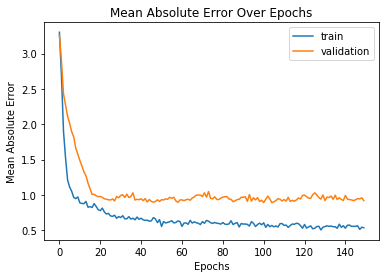

In [17]:
import matplotlib.pyplot as plt

def plot_acc(history):
    plt.plot(np.array(history.history['loss']))
    plt.plot(np.array(history.history['val_loss']))
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.title('Mean Absolute Error Over Epochs')
    
plot_acc(history)

In [8]:
from sklearn.metrics import mean_absolute_error

print('MAE for testing: {}'.format(round(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])),2)))

MAE for testing: 0.77


In [10]:
mlp_user_embedding_weights = (next(iter(filter(lambda x: x.name == 'User-Embedding-MLP', model.layers))).get_weights())

# get the latent embedding for your desired user
user_latent_matrix = mlp_user_embedding_weights[0]

desired_user_id = 38 # User: Xinyue Liu 
one_user_vector = user_latent_matrix[desired_user_id,:]
one_user_vector = np.reshape(one_user_vector, (1,8))

from sklearn.cluster import KMeans

print('\nPerforming kmeans to find the nearest users...')
# get similar users
kmeans = KMeans(n_clusters=20, random_state=0, verbose=0).fit(user_latent_matrix)
desired_user_label = kmeans.predict(one_user_vector)
user_label = kmeans.labels_
neighbors = []
for user_id, user_label in enumerate(user_label):
    if user_label == desired_user_label:
        neighbors.append(user_id)
print('Found {0} neighbor users.'.format(len(neighbors))) 


Performing kmeans to find the nearest users...
Found 2 neighbor users.


In [11]:
# get the movies in 3 similar users' movies
movies = []
for user_id in neighbors:
    movies += list(rating_stack2[rating_stack2['user_id'] == int(user_id)]['item_id'])
movies = list(set(movies))
print('Found {0} neighbor movies from these users.'.format(len(movies))) 

Found 19 neighbor movies from these users.


In [12]:
users = np.full(len(movies), desired_user_id, dtype='int32')
items = np.array(movies, dtype='int32')

print('\nRanking most likely tracks using the NeuMF model...')
# and predict tracks for my user
results = model.predict([users,items],batch_size=10, verbose=0) 
results = results.tolist()
print('Ranked the movies!')


Ranking most likely tracks using the NeuMF model...
Ranked the movies!


In [13]:
results = pd.DataFrame(results, columns=['Rating']).astype("float")
items = pd.DataFrame(items, columns=['item_id']).astype("int")
results = pd.concat([items, results], ignore_index=True, sort=False, axis=1)
results.columns =['item_id', 'Rating'] 

results_df = pd.DataFrame(np.nan, index=range(len(results)), columns=['Rating','Movie'])

# loop through and get the ratings (of being interested by desired user according to my model)
for index, row in results.iterrows():
    results_df.loc[index] = [row['Rating'], rating_stack2[rating_stack2['item_id'] == row['item_id']].iloc[0]['item_name']]
                         
results_df = results_df.sort_values(by=['Rating'], ascending=False)

results_df.head(5)

,Rating,Movie
16,4.591757,The Lord of the Rings III
14,4.512663,The Lord of the Rings I
11,4.501999,The Godfather
12,4.300378,The Godfather Part II
18,4.293344,The Shawkshank Redemption


In [14]:
rating_stack2[rating_stack2['user_id']==38]

,user_name,item_name,rating,user_id,item_id
362,Xinyue Liu,The Godfather,5,38,11
365,Xinyue Liu,The Lord of the Rings III,5,38,16
372,Xinyue Liu,The Lord of the Rings I,4,38,14
375,Xinyue Liu,The Lord of the Rings II,4,38,15
